In [2]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

In [26]:
# What exactly are the colunns here? Amplitude of waves at a specific time?
# My equivalent = peak strain at a specific time

# Build the target function, misfit to this is what is being minimized
@as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector]) # input variable types and output variable type(s)
def two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    y_out = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    y_out = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    # print(b2)
    
    # Make second straight line
    y_out[i] = m2*x[i] + b2

    return y_out

# Build the target function, misfit to this is what is being minimized
def non_pytensor_two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    yout = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    yout = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    yout[i] = m2*x[i] + b2

    return yout

In [27]:
path = '/Users/sydneydybing/StrainProject/2024/taiwan_strain_data/'
events = pd.read_csv(path + 'events_csv.csv')
snr_array = pd.read_csv(path + 'station_data_hypdists_snrs.csv')
snr_array

,Sta,Lat,Lon,Depth(m),2009_hyp_dist_km,2013_hyp_dist_km,2018_hyp_dist_km,snrs_2009,snrs_2013,snrs_2018
0,BCWB,24.2184,121.6891,-192,69.496535,74.182696,7.066640,-,-,-
1,TRKB,24.1614,121.6127,-192,61.088805,65.767547,9.697232,-,1152.20250487,3719.0718215
2,NTTB,24.1728,121.5259,-175,60.587926,65.180780,18.587874,-,-,-
3,SJNB,24.1073,121.6006,-193,54.988063,59.668808,12.226300,-,1534.07924347,130.500478359
4,HGSB,23.4903,121.4237,-266,15.739505,11.125139,79.319331,-,439.289654937,372.018353576
5,CHMB,23.4868,121.4703,-191,15.969342,11.924641,78.079695,-,348.253341927,40.3376474275
6,SSNB,23.4423,121.3981,-185,21.504342,16.833483,85.224271,-,766.890947625,129.005945014
7,ZANB,23.3947,121.4585,-218,26.068219,21.740867,88.175343,-,3295.27964074,106.461336916
8,FBRB,23.1406,121.2796,-200,56.994188,52.307853,120.756809,-,410.300738921,80.3548941939
9,SSTB,23.1340,121.3782,-199,55.447392,50.858196,118.191393,-,359.179515365,47.0870229521


In [97]:
stas_list = []
hypdist_list = []
xhighs_list = []
m1s_list = []
m2s_list = []
xinters_list = []
sigmas_list = []
trans_time_list = []

counter = 0

for ii in range(len(events)):
    
    evt_id = events['evt_id'][ii]
    print(evt_id)

    for idx in range(len(snr_array)):

        sta = snr_array['Sta'][idx]
        
        if evt_id == '2009-10-03_M6.1':
            hypdist = snr_array['2009_hyp_dist_km'][idx]
        elif evt_id == '2013-10-31_M6.3':
            hypdist = snr_array['2013_hyp_dist_km'][idx]
        elif evt_id == '2018-02-04_M6.1':
            hypdist = snr_array['2018_hyp_dist_km'][idx]
        
        int_hypdist = int(hypdist)

        # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
        xlow = 10
        xhigh = 20 # For Taiwan
        
        if evt_id == '2013-10-31_M6.3' and sta == 'SSTB':
            pass
        else:
            continue
        
        try:
            pst = read(path + 'filtered_abs_peak_post_p/' + evt_id + '/' + sta + '.mseed')
            counter += 1
        except:
            continue

        print('Processing ' + str(sta))

        times = pst[0].times()
        data = pst[0].data
        log10_data = np.log10(data)
        samp_rate = pst[0].stats.sampling_rate
        print(samp_rate)

        # Split into x and y vectors
        vec_start = int(xlow*samp_rate)
        vec_end = int(xhigh*samp_rate)
        xobserved = times[vec_start:vec_end]
        yobserved = log10_data[vec_start:vec_end]
        
        # Initial values (origin)
        x0 = xobserved[0]
        y0 = yobserved[0]

        # In order to pass the x variable into the target function it needs to be converted to a Theano "shared" variable
        pt_xobserved = pytensor.shared(xobserved)
        pt_x0 = pytensor.shared(x0)
        pt_y0 = pytensor.shared(y0)

        # MCMC run parameters, these are good numbers for a "production" run. If you are fooling arund these can be lower to iterate faster
        Nburn = 3000 # burn in samples that get discarded
        Nmcmc = 10000 # bump to at least 5-10k - increase this after ficing the uniform part 
        Nchains = 4
        Ncores = 1

        # Bounds for the prior distributions - expect this, but not enforce
        m1_low = 0 ; m1_high = 1000 # lowest slope 0, highest 10
        m2_low = 0 ; m2_high = 100
        # b1_low = -50 ; b1_high = 0 # lowest y-intercept -20, highest 0
        xinter_low = 10 ; xinter_high = 25 # location of the line slope change

        # Define the Bayesian model
        with pm.Model() as model:
            
            # Priors for unknown model parameters
            m1 = pm.Normal('m1', mu = 10, sigma = 3) # Could change mu (mean)
            m2 = pm.Normal('m2', mu = 0, sigma = 1)
            xinter = pm.HalfNormal('xinter', sigma = 1)
            sigma = pm.HalfNormal('sigma', sigma = 1) # Observation error
            
            # m1 = pm.Uniform('m1', lower = m1_low, upper = m1_high) # Random sampling, uninformative prior
            # m2 = pm.Uniform('m2', lower = m2_low, upper = m2_high)
            # xinter = pm.Uniform('xinter', lower = xinter_low, upper = xinter_high)
            # sigma = pm.HalfCauchy('sigma', beta = 10, initval = 1.) # Observation error
            
            # Expected value of outcome - the function we're trying to fit
            mu = two_straight_lines(pt_xobserved, m1, m2, xinter, pt_x0, pt_y0) 
            # print(mu)

            # This is the model - likelihood (sampling distribution) of observations in dataset
            likelihood = pm.Normal('y', mu = mu, observed = yobserved, sigma = sigma) # Normal distribution with a mean that is the y_out array?

            # NUTS sampler (default) is gradient based and won't work, use metropolis
            step = pm.Metropolis() # Try a smaller factor # Check out Diego's book - condition for accepting new sample as "better" than last

            # This runs the MCMC sampler
            mcmc = pm.sample(Nmcmc, tune = Nburn, chains = Nchains, cores = Ncores, step = step)

        # Done, now is post-processing to get the data out of the sampler
        posterior = az.extract(mcmc)
        
        # Summary
        print(az.summary(mcmc, kind = 'stats'))

        # Unwrap coeficients - WRITE LINES TO SAVE THE ARRAYS!!!
        m1_array = posterior.m1.values
        m1 = np.mean(m1_array)
        print('m1 mean: ' + str(round(m1,2)))

        m2_array = posterior.m2.values
        m2 = np.mean(m2_array)
        print('m2 mean: ' + str(round(m2,2)))

        xinter_array = posterior.xinter.values
        xinter = np.mean(xinter_array)
        print('xinter Mean: ' + str(round(xinter,2)))

        sigma_array = posterior.sigma.values
        sigma = np.mean(sigma_array)

        # Lines!
        print('x0: ' + str(x0))
        print('y0: ' + str(y0))
        b1 = y0 - m1*x0
        b2 = m1*(xinter+10) + b1 - m2*(xinter+10)
        print('b1: ' + str(b1))
        print('b2: ' + str(b2))

        # Make plot to check stuff
        xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
        # print(xpredicted)
        # ypredicted = np.ones(len(xpredicted))
        ypredicted = m1*xpredicted + b1
        # print(ypredicted)
        i = np.where(xpredicted > xinter+10)[0]
        # print(i)
        ypredicted[i] = m2*xpredicted[i] + b2

        # Get one-sigma region (need to obtain a ton of forward models and get stats)
        N = len(posterior.m1.values)

        yfit = np.zeros((len(xpredicted), N))
        for k in range(N):
            yfit[:,k] = non_pytensor_two_straight_lines(xpredicted,m1_array[k],m2_array[k],xinter_array[k],x0,y0)
        mu = yfit.mean(1)
        sig = yfit.std(1) * 1.95 #for 95% confidence
        mu_plus = mu + sig
        mu_minus = mu - sig

        # Least squares
        mls, bls = np.polyfit(xobserved, yobserved, 1)

        # Find the transition point in ypredicted
        diff = np.round(np.diff(ypredicted), decimals = 5)
        # print(diff)
        first_slope = diff[0]
        # print(first_slope)
        second_slope = diff[-1]
        # print(second_slope)
        where1 = np.where((diff != first_slope) & (diff != second_slope))
        # print(where1)
        trans_idx = np.where((diff != first_slope) & (diff != second_slope))[0][0] + 1

        # Get the transition point
        mcmc_trans_x = xpredicted[trans_idx] # Number
        mcmc_trans_y = ypredicted[trans_idx]

        # Append things
        stas_list.append(sta)
        hypdist_list.append(int_hypdist)
        xhighs_list.append(xhigh)
        m1s_list.append(m1)
        m2s_list.append(m2)
        xinters_list.append(xinter)
        sigmas_list.append(sigma)
        trans_time_list.append(mcmc_trans_x)

        # Plot all solutions
        fig = plt.figure(dpi = 100)
        ax = fig.add_subplot(111)
        ax.set_title(str(sta))

        ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)') # ----------------------
        ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)') # ----------------------
        # ax.plot(xpredicted, mu, color = 'green', linestyle = '--', label = 'yfit')
        # ax.plot(xpredicted, xpredicted * mls + bls, color = 'orange', label = 'np.polyfit least squares')
        ax.scatter(xpredicted[trans_idx], ypredicted[trans_idx], marker = 'o', color = 'black', label = 'Transition at ' + str(round(xpredicted[trans_idx],2)) + ' sec') # ----------------------
        # ax.scatter(closest_trans_x, closest_trans_y, marker = 'o', color = 'green', label = 'Adjusted transition at ' + str(round(closest_trans_x,2)) + ' sec')
        # ax2 = ax.twinx()
        # ax2.plot(xobserved, pythags_arr, color = 'violet')
        # ax2.axhline(closest_trans_x, color = 'violet', linestyle = '--')
        ax.fill_between(xpredicted, mu_plus, mu_minus, color = 'gray', alpha = 0.2, label = '95% confidence') # 95% confidence interval # ----------------------
        ax.set_xlabel('Time (s) - p-wave at 10s')
        ax.set_ylabel('log10 of peak strain')
        # ax.set_xlim(10,13)
        ax.legend()

        plt.show()

#         # Create folder for the event
#         array_save_dir = path + 'filtered_mcmc_arrays/' + str(sta) + '/'
#         if os.path.isdir(array_save_dir):
#             pass
#         else:
#             os.makedirs(array_save_dir)

#         # Save arrays
#         np.save(array_save_dir + 'xobserved.npy', xobserved)
#         np.save(array_save_dir + 'yobserved.npy', yobserved)
#         np.save(array_save_dir + 'xpredicted.npy', xpredicted)
#         np.save(array_save_dir + 'ypredicted.npy', ypredicted)
#         np.save(array_save_dir + 'forward_mus.npy', mu)
#         np.save(array_save_dir + 'foward_sigs.npy', sig)

#         # Save posterior
#         summary = az.summary(mcmc)
#         summary.to_csv(array_save_dir + 'summary.csv')
#         # posterior = az.extract(mcmc)
#         # posterior.to_netcdf(path = array_save_dir + 'posterior.nc', mode = 'w') # Doesn't work right now

#         # Save figure
#         fig_save_dir = path + 'figures/filtered_mcmc_plots/'
#         if os.path.isdir(fig_save_dir):
#             pass
#         else:
#             os.makedirs(fig_save_dir)

#         plt.savefig(fig_save_dir + sta + '.png', format = 'PNG', dpi = 400)
#         plt.close()

#         print(str(sta) + ' done')

2009-10-03_M6.1
2013-10-31_M6.3
Processing SSTB
10.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%
m1       3.074  0.478   2.223    3.833
m2       0.100  0.007   0.086    0.109
xinter  10.700  0.135  10.528   10.952
sigma    0.126  0.030   0.087    0.185
m1 mean: 3.07
m2 mean: 0.1
xinter Mean: 10.7
x0: 10.0
y0: -0.4231500747016974
b1: -31.16644851664125
b2: 30.40732420515258


IndexError: index 0 is out of bounds for axis 0 with size 0

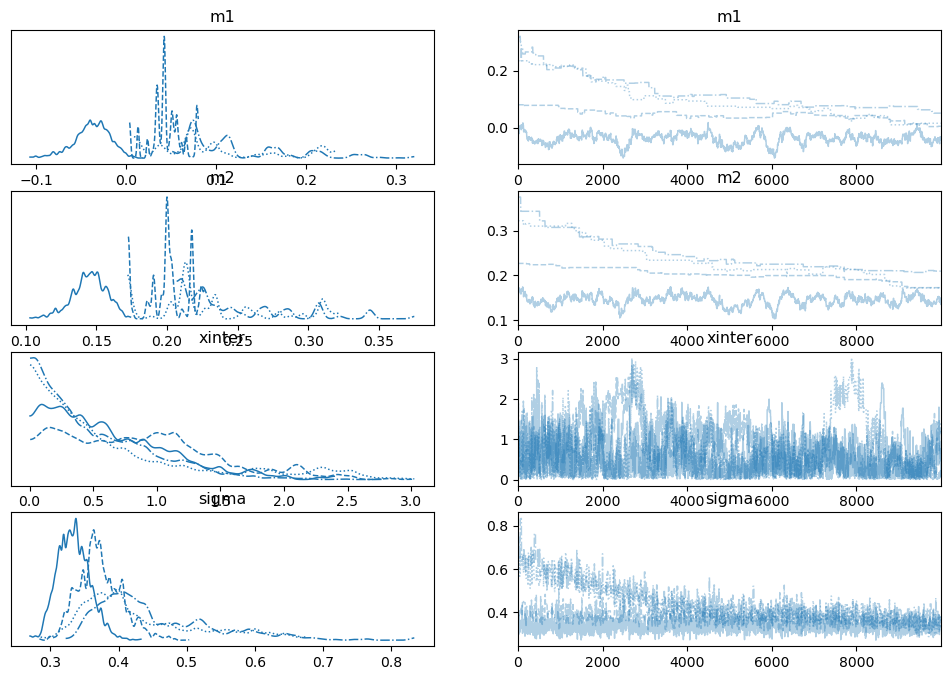

In [98]:
az.plot_trace(mcmc);

In [83]:
az.summary(mcmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m1,2.823,3.990,-0.154,11.006,1.981,1.516,4.0,6.0,3.90
m2,0.062,0.009,0.049,0.076,0.005,0.004,4.0,5.0,3.42
xinter,5.360,5.339,0.001,11.122,2.668,2.045,5.0,92.0,2.81
sigma,0.201,0.034,0.143,0.241,0.016,0.012,5.0,12.0,2.19


In [24]:
b1

-189.71811654340382

In [25]:
b2

69.53134320552547

In [ ]:
counter

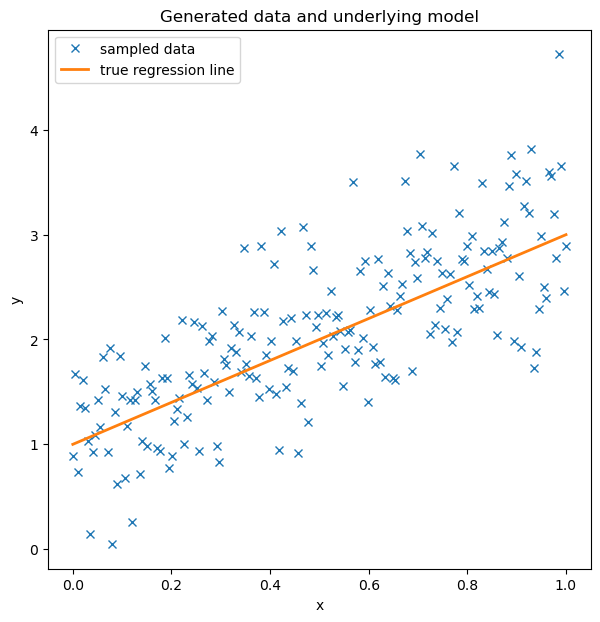

In [38]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [40]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 28 seconds.


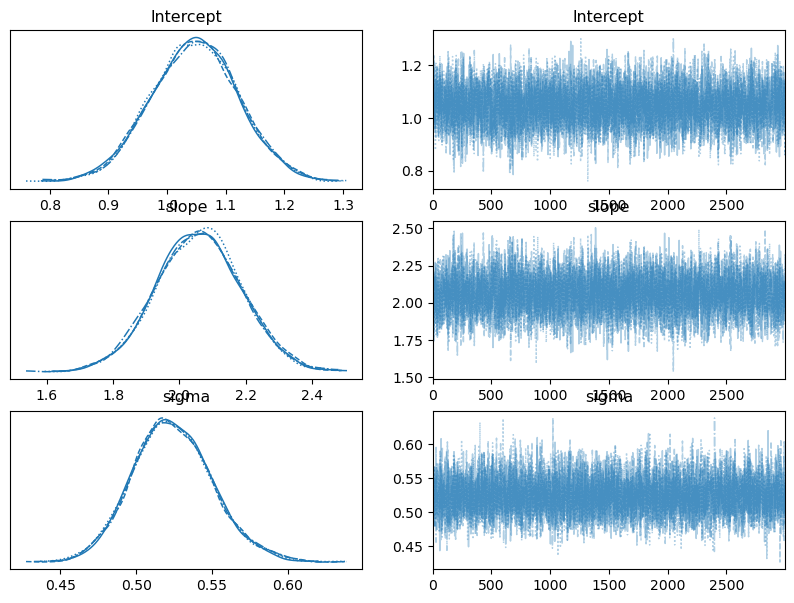

In [41]:
az.plot_trace(idata, figsize=(10, 7));

In [ ]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

np.save(path_to_files + 'filtered_mcmc_arrays/summary_array.npy', mcmc_array)

In [ ]:
mcmc_array.shape

In [ ]:
mcmc_array = np.load(path_to_files + 'filtered_mcmc_arrays/summary_array.npy')
mcmc_array[0]

# Columns:
# 0. Event name
# 1. Magnitude
# 2. Station name
# 3. Hypocentral distance (km)
# 4. xhigh
# 5. m1 slope
# 6. m2 slope
# 7. intersection point
# 8. sigma
# 9. transition time

In [ ]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(6,7.25,0.05)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)
    

In [ ]:
# Get mean transition time by event

unique_eventids = np.unique(mcmc_array[:,0])
unique_eventids

mags = []
mean_trans_times = []

for uni_id in unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = mcmc_array[i,9].astype(float)-10
    mag = mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    mags.append(mag)
    mean_trans_times.append(mean_trans_time)
    
mags = np.array(mags)
mean_trans_times = np.array(mean_trans_times)

In [ ]:
m, b = np.polyfit(mags, np.log10(mean_trans_times), 1)
ma, ba = np.polyfit(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10), 1)

In [ ]:
# plt.scatter(mcmc_array[:,3].astype(float), mcmc_array[:,9].astype(float)-10)
# plt.xlabel('Hypocentral distance (km)')
# plt.ylabel('Transition time (s)')
# plt.show()



plt.scatter(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10))
plt.scatter(mags, np.log10(mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
plt.plot(mags, mags * m + b, color = 'red', lw = 1)
plt.plot(mcmc_array[:,1].astype(float), mcmc_array[:,1].astype(float) * ma + ba, color = 'C0', lw = 1)
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
# plt.semilogy()
plt.legend()
plt.show()

plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,5].astype(float))
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 1 slope')
plt.show()

plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,6].astype(float))
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 2 slope')
plt.show()

In [ ]:
# mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
#                              np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
#                              np.array(sigmas_list), np.array(trans_time_list)))

pd_mcmc = pd.DataFrame(mcmc_array, columns = ['eq_id', 'mag', 'sta', 'hypdist', 'xhigh', 'm1', 'm2', 'xinter', 'sigma', 'trans_time'])
pd_mcmc.to_csv(path_to_files + 'filtered_mcmc_arrays/mcmc_results_summary.csv', index = False)

In [ ]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path_to_files + 'filtered_mcmc_arrays/mcmc_results_summary.csv')
mcmc_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time
0,2023-04-13_M6,6.0,B012,299,60,0.237385,0.014034,13.037766,0.106723,13.1
1,2023-04-13_M6,6.0,B927,349,60,0.520998,0.006502,13.746085,0.151608,13.8
2,2023-04-13_M6,6.0,B928,330,60,0.473223,0.010361,12.366934,0.085590,12.4
3,2022-12-20_M6.4,6.4,B030,406,40,0.169725,0.031976,13.733588,0.111113,13.8
4,2022-12-20_M6.4,6.4,B032,359,40,0.143660,0.033170,14.465866,0.101163,14.5
...,...,...,...,...,...,...,...,...,...,...
195,2010-01-10_M6.5,6.5,B035,232,35,0.519965,0.025339,13.499214,0.170624,13.5
196,2010-01-10_M6.5,6.5,B036,233,35,0.515825,0.026782,13.503401,0.170778,13.6
197,2010-01-10_M6.5,6.5,B057,344,35,0.123378,0.020024,15.241258,0.067794,15.3
198,2010-01-10_M6.5,6.5,B933,89,35,0.740438,0.048036,13.192635,0.155758,13.2


In [31]:
# mcmc_results_class_by_eye = pd.read_csv(path_to_files + 'mcmc_results_summary.csv', usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
# mcmc_results_class_by_eye

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time,behavior
0,2023-04-13_M6,6.0,B003,423,60,0.276567,0.012251,14.075615,0.141517,14.1,b
1,2023-04-13_M6,6.0,B004,398,60,0.523278,0.010967,12.877702,0.101206,12.9,g
2,2023-04-13_M6,6.0,B005,468,60,0.392836,0.009337,12.057298,0.075473,12.1,g
3,2023-04-13_M6,6.0,B009,456,60,0.428682,0.000518,12.471551,0.079256,12.5,g
4,2023-04-13_M6,6.0,B012,299,60,0.420404,0.013704,13.220529,0.112984,13.3,g
...,...,...,...,...,...,...,...,...,...,...,...
321,2010-01-10_M6.5,6.5,B066,499,35,0.228458,0.026041,15.608228,0.096790,15.7,g
322,2010-01-10_M6.5,6.5,B933,89,35,1.205989,0.046212,12.710480,0.220511,12.8,g
323,2010-01-10_M6.5,6.5,B934,123,35,0.258354,0.063122,12.957077,0.087686,13.0,b
324,2010-01-10_M6.5,6.5,B935,96,35,1.338175,0.021897,12.540953,0.210012,12.6,g


In [41]:
# good_results = mcmc_results_class_by_eye[mcmc_results_class_by_eye['behavior'] == 'g']
# bad_results = mcmc_results_class_by_eye[mcmc_results_class_by_eye['behavior'] == 'b']
# good_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time,behavior
1,2023-04-13_M6,6.0,B004,398,60,0.523278,0.010967,12.877702,0.101206,12.9,g
2,2023-04-13_M6,6.0,B005,468,60,0.392836,0.009337,12.057298,0.075473,12.1,g
3,2023-04-13_M6,6.0,B009,456,60,0.428682,0.000518,12.471551,0.079256,12.5,g
4,2023-04-13_M6,6.0,B012,299,60,0.420404,0.013704,13.220529,0.112984,13.3,g
5,2023-04-13_M6,6.0,B927,349,60,0.644048,0.006067,12.064490,0.108054,12.1,g
...,...,...,...,...,...,...,...,...,...,...,...
319,2010-01-10_M6.5,6.5,B054,377,35,0.474619,0.001973,13.653904,0.078392,13.7,g
320,2010-01-10_M6.5,6.5,B057,344,35,0.379983,0.023154,14.384422,0.117667,14.4,g
321,2010-01-10_M6.5,6.5,B066,499,35,0.228458,0.026041,15.608228,0.096790,15.7,g
322,2010-01-10_M6.5,6.5,B933,89,35,1.205989,0.046212,12.710480,0.220511,12.8,g


In [51]:
# plt.figure(dpi = 400)
# plt.scatter(bad_results.hypdist.values, bad_results.xinter.values, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
# plt.scatter(good_results.hypdist.values, good_results.xinter.values, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
# plt.xlabel('Hypocentral distance (km)')
# plt.ylabel('Transition time (s)')
# plt.legend()
# # plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_hypdist_vs_transtime.png', format = 'PNG')
# plt.close()

# plt.figure(dpi = 400)
# plt.scatter(bad_results.mag.values, bad_results.xinter.values, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
# plt.scatter(good_results.mag.values, good_results.xinter.values, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Transition time (s)')
# plt.legend()
# # plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_mag_vs_transtime.png', format = 'PNG')
# plt.close()

# plt.figure(dpi = 400)
# plt.scatter(bad_results.mag.values, bad_results.m1.values, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
# plt.scatter(good_results.mag.values, good_results.m1.values, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Line 1 slope')
# plt.legend()
# # plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_mag_vs_m1.png', format = 'PNG')
# plt.close()

# plt.figure(dpi = 400)
# plt.scatter(bad_results.mag.values, bad_results.m2.values, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
# plt.scatter(good_results.mag.values, good_results.m2.values, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Line 2 slope')
# plt.legend()
# # plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_mag_vs_m2.png', format = 'PNG')
# plt.close()

In [93]:
summary = az.summary(mcmc)

In [94]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m1,1.608,0.390,1.130,2.124,0.274,0.231,2.0,11.0,2.84
m2,0.013,0.003,0.011,0.019,0.002,0.001,3.0,21.0,2.24
xinter,11.131,0.335,10.699,11.574,0.235,0.198,2.0,10.0,2.69
sigma,0.106,0.037,0.067,0.177,0.024,0.020,2.0,13.0,2.32


In [77]:
summary['mean']

m1         0.302
m2         0.039
xinter    12.971
sigma      0.163
Name: mean, dtype: float64

In [82]:
m1 = summary['mean'].iloc[0]
m2 = summary['mean'].iloc[1]
xinter = summary['mean'].iloc[2]
sigma = summary['mean'].iloc[3]

In [85]:
print(sigma)

0.163


In [87]:
# Done, now is post-processing to get the data out of the sampler

summary = az.summary(mcmc)

# Unwrap coeficients
m1 = summary['mean'].iloc[0]
m2 = summary['mean'].iloc[1]
xinter = summary['mean'].iloc[2]
sigma = summary['mean'].iloc[3]
b1 = y0 - m1*x0
b2 = m1*xinter + b1 - m2*xinter

In [88]:
# Make plot to check stuff
xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
ypredicted = np.ones(len(xpredicted))
ypredicted = m1*xpredicted + b1
i = np.where(xpredicted > xinter)[0]
ypredicted[i] = m2*xpredicted[i] + b2

In [90]:
posterior = az.extract(mcmc)

In [95]:
posterior

<xarray.Dataset> Size: 224kB
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
Data variables:
    m1       (sample) float64 32kB 0.2794 0.2794 0.2794 ... 0.3114 0.3114 0.3114
    m2       (sample) float64 32kB 0.0466 0.0466 0.0466 ... 0.04077 0.04077
    xinter   (sample) float64 32kB 12.98 12.98 12.99 12.99 ... 12.95 12.94 12.94
    sigma    (sample) float64 32kB 0.1522 0.1522 0.1522 ... 0.1575 0.1575 0.1575
Attributes:
    created_at:                 2024-03-05T10:45:23.481163
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              8.208245038986206
    tuning_steps:               1000

In [99]:
len(posterior.m1.values)

4000